In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
images_df= sc.binaryFiles("hdfs://172.17.41.8:9000/ADACA1/baseball,hdfs://172.17.41.8:9000/ADACA1/tennis")

In [4]:
images_df

org.apache.spark.api.java.JavaPairRDD@326d9b80

In [5]:
from PIL import Image
import io

image_data = images_df.collect()
image_pixels = []
image_labels = []

for image_path, image_byte in image_data:
    image = Image.open(io.BytesIO(image_byte))
    pixels = np.array(image)
    
    image_name = image_path.split('/')[-1].split('.')[0]
    
    image_pixels.append(pixels)
    image_labels.append(image_name)  

df = pd.DataFrame({'image': image_pixels, 'label': image_labels})

In [6]:
df.head()

,image,label
0,"[[[136, 103, 96], [134, 101, 94], [137, 104, 9...",baseball1
1,"[[[89, 89, 53], [89, 89, 53], [88, 88, 50], [8...",baseball10
2,"[[[4, 5, 10], [4, 5, 10], [4, 5, 10], [4, 5, 1...",baseball100
3,"[[[165, 152, 136], [163, 150, 134], [171, 157,...",baseball101
4,"[[[10, 7, 16], [10, 7, 14], [9, 6, 13], [10, 8...",baseball102


In [7]:
df.shape

(696, 2)

In [8]:
type(df)

pandas.core.frame.DataFrame

In [9]:
def resize_image(img):
    return cv2.resize(img, (235, 235))

df['image'] = df['image'].apply(resize_image)

In [10]:
df.head()

,image,label
0,"[[[136, 103, 96], [140, 107, 100], [141, 108, ...",baseball1
1,"[[[89, 89, 53], [87, 87, 48], [84, 85, 42], [8...",baseball10
2,"[[[4, 5, 10], [4, 5, 10], [4, 5, 10], [4, 5, 1...",baseball100
3,"[[[164, 151, 135], [161, 147, 134], [155, 141,...",baseball101
4,"[[[10, 7, 15], [10, 8, 12], [29, 28, 27], [35,...",baseball102


In [11]:
from sklearn.model_selection import train_test_split

X = df['image']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Training set shape: (556,) (556,)
Testing set shape: (140,) (140,)


In [12]:
X_train = np.stack(X_train)
X_test = np.stack(X_test)

# Verificar las formas de los conjuntos de entrenamiento y prueba después de la conversión
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (556, 235, 235, 3) (556,)
Testing set shape: (140, 235, 235, 3) (140,)


In [13]:
X_train.shape

(556, 235, 235, 3)

In [14]:
X_train1 = X_train.reshape(X_train.shape[0], 235, 235, 3).astype(np.float32)
X_test1 = X_test.reshape(X_test.shape[0], 235, 235, 3).astype(np.float32)
print("Training set shape for CNN:", X_train1.shape)
print("Testing set shape for CNN:", X_test1.shape)

Training set shape for CNN: (556, 235, 235, 3)
Testing set shape for CNN: (140, 235, 235, 3)


In [15]:
#normalize data
X_train1/=255
X_test1/=255

In [16]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Solo necesitas identificar si las etiquetas contienen 'tennis' o 'baseball'
# Puedes usar una comprensión de lista para esto
y_train_category = ['tennis' if 'tennis' in label else 'baseball' for label in y_train]
y_test_category = ['tennis' if 'tennis' in label else 'baseball' for label in y_test]

# Usamos el LabelEncoder para convertir las etiquetas de texto a números
label_encoder = LabelEncoder()
all_categories = y_train_category + y_test_category
label_encoder.fit(all_categories)

# Transformamos las etiquetas a valores numéricos
y_train_encoded = label_encoder.transform(y_train_category)
y_test_encoded = label_encoder.transform(y_test_category)

# Convertimos las etiquetas a codificación one-hot
num_classes = len(label_encoder.classes_)
y_train_encoded = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

print("Shape of y_train_encoded:", y_train_encoded.shape)
print("Shape of y_test_encoded:", y_test_encoded.shape)


2024-03-25 14:41:56.334154: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-25 14:41:56.792063: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 14:41:58.009230: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Shape of y_train_encoded: (556, 2)
Shape of y_test_encoded: (140, 2)


In [17]:
y_train_binary = y_train_encoded[:, 1]
y_test_binary = y_test_encoded[:, 1]

# Ahora tus etiquetas tendrán la forma (N, 1)
print("Shape of y_train_binary:", y_train_binary.shape)
print("Shape of y_test_binary:", y_test_binary.shape)

Shape of y_train_binary: (556,)
Shape of y_test_binary: (140,)


In [18]:
print("Number of Classes:", num_classes)


Number of Classes: 2


In [19]:
print("Classes:", label_encoder.classes_)


Classes: ['baseball' 'tennis']


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Definir el modelo
model = Sequential([
    Conv2D(64, (5, 5), activation='relu', input_shape=(235, 235, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    Conv2D(128, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='sigmoid')  
])

/home/kent/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-03-25 14:41:59.855785: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 14:41:59.856093: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 231, 231, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 115, 115, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 115, 115, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 111, 111, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 55, 55, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 51, 51, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,120,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,739,649 (21.90 MB)

 Trainable params: 5,739,649 (21.90 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [23]:
history=model.fit(X_train1, y_train_binary, epochs=30, batch_size=32, validation_data=(X_test1, y_test_binary))


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5600 - loss: 0.9313 - val_accuracy: 0.8357 - val_loss: 0.4164
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7599 - loss: 0.5587 - val_accuracy: 0.7786 - val_loss: 0.5430
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7897 - loss: 0.4839 - val_accuracy: 0.8429 - val_loss: 0.4203
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8257 - loss: 0.4283 - val_accuracy: 0.8500 - val_loss: 0.3862
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8492 - loss: 0.3375 - val_accuracy: 0.8357 - val_loss: 0.4377
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8707 - loss: 0.3453 - val_accuracy: 0.8500 - val_loss: 0.3870
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8636 - loss: 0.3708 - val_accuracy: 0.7857 - val_loss: 0.4928
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8594 - loss: 0.3849 - val_accuracy: 0.8929 - val_loss:

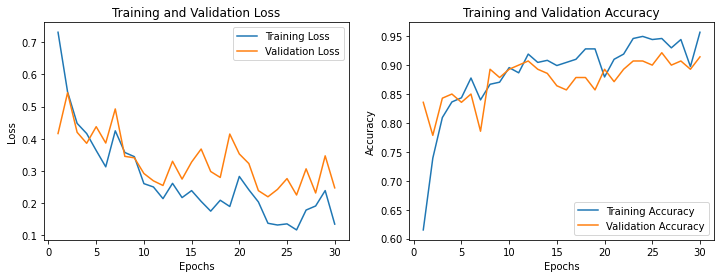

In [24]:
import matplotlib.pyplot as plt

# Obtener la pérdida y precisión del historial de entrenamiento
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Crear un rango de épocas para el eje x
epochs_range = range(1, len(train_loss) + 1)

# Graficar la pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Graficar la precisión
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()
